# Cardiovascular Risk Prediction — Production-ready

This notebook is engineered for hackathons and quick production demos: reproducible preprocessing, robust pipeline, CV model selection, calibration, threshold tuning, explainability, and artifact saving.

_Run cells in order. If your dataset path differs, update the PRIMARY_CSV variable in the first code cell._

### Detected columns & suggested candidate target columns

**Columns in your CSV (first 50 shown):**

patient_id, age, gender, race, smoking_status, diabetes_type, hypertension, previous_heart_attack, family_history_cvd, bmi_baseline, cholesterol_baseline, creatinine_baseline, enrollment_date, risk_category

**Candidate binary columns detected (may be targets):**

- `hypertension` — sample unique values: ['yes', 'no']
- `previous_heart_attack` — sample unique values: ['no', 'yes']
- `family_history_cvd` — sample unique values: ['yes', 'no']

**Action:** If your true target column is not auto-detected by the notebook, set the variable `TARGET_MANUAL` at the start of the notebook to the exact column name (example: `TARGET_MANUAL = 'hypertension'`).


In [18]:
# Optional: force target column by setting the env var TARGET_MANUAL or editing this cell.
import os
TARGET_MANUAL = os.getenv("TARGET_MANUAL", "")
if TARGET_MANUAL:
    print("TARGET_MANUAL set to:", TARGET_MANUAL)
else:
    print("TARGET_MANUAL not set. Notebook will attempt to infer target automatically.")

TARGET_MANUAL not set. Notebook will attempt to infer target automatically.


In [19]:

# Setup & imports
import os, json
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, balanced_accuracy_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
from joblib import dump, load

RANDOM_STATE = 42
CV_FOLDS = int(os.getenv("CV_FOLDS", 5))
SEARCH_SPACE_SIZE = os.getenv("SEARCH_SPACE_SIZE", "small")
PRIMARY_METRIC = os.getenv("PRIMARY_METRIC", "f1")
MODEL_DIR = "artifacts"
os.makedirs(MODEL_DIR, exist_ok=True)

pd.options.display.max_columns = 200
print("Config:", {"CV_FOLDS": CV_FOLDS, "SEARCH_SPACE_SIZE": SEARCH_SPACE_SIZE, "PRIMARY_METRIC": PRIMARY_METRIC})


Config: {'CV_FOLDS': 5, 'SEARCH_SPACE_SIZE': 'small', 'PRIMARY_METRIC': 'f1'}


In [20]:

# Data loading - change path if needed
PRIMARY_CSV = "cardiovascular_patients.csv"
if not os.path.exists(PRIMARY_CSV):
    raise FileNotFoundError(f"Primary CSV not found at {PRIMARY_CSV}. Please upload your file to /mnt/data/ or change PRIMARY_CSV.")
df = pd.read_csv(PRIMARY_CSV)
print("Loaded:", df.shape)
df.head(3)


Loaded: (50, 14)


,patient_id,age,gender,race,smoking_status,diabetes_type,hypertension,previous_heart_attack,family_history_cvd,bmi_baseline,cholesterol_baseline,creatinine_baseline,enrollment_date,risk_category
0,P001,67,Male,White,Former,Type2,Yes,No,Yes,28.5,245,1.2,2023-01-15,High
1,P002,54,Female,Black,Never,NaN,Yes,No,Yes,32.1,198,0.9,2023-01-20,Medium
2,P003,72,Male,Hispanic,Current,Type2,Yes,Yes,No,29.8,267,1.4,2023-01-25,High


In [21]:

# Infer and clean target column
POSSIBLE_TARGETS = ["target","label","risk","cardio","event","outcome","has_cvd","cvd","y","target_label"]

def infer_target(df):
    for t in POSSIBLE_TARGETS:
        if t in df.columns:
            return t
    cols_lower = {c.lower(): c for c in df.columns}
    for t in POSSIBLE_TARGETS:
        if t in cols_lower:
            return cols_lower[t]
    # fallback: find a binary-like column
    for c in df.columns:
        unique = pd.unique(df[c].dropna().astype(str).str.lower())
        if set(unique).issubset({"0","1","true","false","yes","no","y","n","t","f"}):
            return c
    return None

target_col = infer_target(df)
if target_col is None:
    raise ValueError("Could not infer target column. Rename your target to a common name or set TARGET env var.")

print("Target:", target_col)

def normalize_target(s):
    if s.dtype == bool:
        return s.astype(int)
    if pd.api.types.is_numeric_dtype(s):
        uniq = pd.unique(s.dropna())
        if set(uniq).issubset({0,1}):
            return s.astype(int)
        if s.dropna().between(0,1).all():
            return (s >= 0.5).astype(int)
    s2 = s.astype(str).str.strip().str.lower()
    mapping = {"yes":1,"y":1,"true":1,"t":1,"1":1,"no":0,"n":0,"false":0,"f":0,"0":0}
    mapped = s2.map(mapping)
    if mapped.isna().any():
        raise ValueError("Unmapped target values encountered. Sample: " + str(mapped[ mapped.isna() ].unique()[:10]))
    return mapped.astype(int)

df = df.dropna(subset=[target_col]).copy()
df[target_col] = normalize_target(df[target_col])
y = df[target_col]
X = df.drop(columns=[target_col])
print("Class balance:", y.value_counts(normalize=True).to_dict())


Target: hypertension
Class balance: {1: 0.78, 0: 0.22}


In [22]:
# Preprocessing: numeric vs categorical
numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numeric cols:", len(numeric_cols), "Categorical cols:", len(categorical_cols))

# Use dense OHE for simplicity; if your dataset is huge consider sparse OHE and adjust scaler with_mean=False
try:
    ohe = OneHotEncoder(handle_unknown="ignore")
    sparse_ohe = False
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore")
    sparse_ohe = False

num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_pipeline = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", ohe)])

preprocessor = ColumnTransformer([("num", num_pipeline, numeric_cols), ("cat", cat_pipeline, categorical_cols)], remainder="drop")
preprocessor

Numeric cols: 4 Categorical cols: 9


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'bmi_baseline', 'cholesterol_baseline',
                                  'creatinine_baseline']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['patient_id', 'gender', 'race',
                                  'smoking_status', 'diabetes_type',
                                  'previous_heart_attack', 'family_history_cvd',
                                  'enrollment_date', 'risk_category'])])

In [23]:

# Models and grid (conservative)
logreg = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear", random_state=RANDOM_STATE)
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced")
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

if SEARCH_SPACE_SIZE == "small":
    param_grid = [
        {"clf": [logreg], "clf__C": [0.1, 1.0]},
        {"clf": [rf], "clf__n_estimators": [100], "clf__max_depth": [8, None]},
        {"clf": [gb], "clf__n_estimators": [100], "clf__learning_rate": [0.05, 0.1], "clf__max_depth": [2,3]},
    ]
else:
    param_grid = [
        {"clf": [logreg], "clf__C": [0.05, 0.1, 0.5, 1.0]},
        {"clf": [rf], "clf__n_estimators": [200, 400], "clf__max_depth": [None, 8, 14]},
        {"clf": [gb], "clf__n_estimators": [150, 300], "clf__learning_rate": [0.03, 0.05, 0.1], "clf__max_depth": [2,3]},
    ]

pipe = Pipeline([("preprocessor", preprocessor), ("clf", logreg)])

from sklearn.metrics import make_scorer
scorer_map = {"f1": make_scorer(f1_score), "balanced_accuracy": make_scorer(balanced_accuracy_score), "roc_auc": "roc_auc"}
scorer = scorer_map.get(PRIMARY_METRIC, "roc_auc")

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(pipe, param_grid=param_grid, scoring=scorer, cv=cv, n_jobs=-1, verbose=1, error_score="raise")
grid


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'bmi_baseline',
                                                                          'cholesterol_baseline',
                                                                          'creatinine_baseline']),
                                                                        ('cat',
                                                                         Pipeline(...
                                                     solver='liblinear')],
                          'clf__C': [0.1, 1.0]},
                         {'clf': [RandomForestClassifier(class_weight='balanced',
                                                         random_state=42)],
                          'clf__max_depth': [8, None],
                          'clf__n_estimators': [100]},
                         {'clf': [GradientBoostingClassifier(random_state=42)],
                          'clf__learning_rate': [0.05, 0.1],
                          'clf__max_depth': [2, 3],
                          'clf__n_estimators': [100]}],
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=1)

In [24]:

# Fit on a small sample to validate end-to-end flow.
MAX_SAMPLE = 2000
df_small = pd.concat([X, y], axis=1).sample(frac=1.0, random_state=RANDOM_STATE)
if len(df_small) > MAX_SAMPLE:
    df_small = df_small.head(MAX_SAMPLE)
y_small = df_small[target_col]
X_small = df_small.drop(columns=[target_col])

X_train, X_val, y_train, y_val = train_test_split(X_small, y_small, test_size=0.2, stratify=y_small, random_state=RANDOM_STATE)

print("Fitting grid on sample with shapes:", X_train.shape, X_val.shape)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_model = grid.best_estimator_
proba = best_model.predict_proba(X_val)[:,1]
print("ROC AUC:", roc_auc_score(y_val, proba))


Fitting grid on sample with shapes: (40, 13) (10, 13)
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'clf': GradientBoostingClassifier(random_state=42), 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100}
ROC AUC: 1.0


In [25]:

# Calibration
calibrator = CalibratedClassifierCV(best_model, method="isotonic", cv=3)
calibrator.fit(X_train, y_train)
cal_proba = calibrator.predict_proba(X_val)[:,1]

# threshold tuning (f1 by default)
def find_best_threshold(y_true, y_prob):
    best_thr, best_score = 0.5, -1
    for thr in np.linspace(0.05, 0.95, 19):
        p = (y_prob >= thr).astype(int)
        s = f1_score(y_true, p)
        if s > best_score:
            best_score, best_thr = s, thr
    return best_thr, best_score

best_thr, best_score = find_best_threshold(y_val, cal_proba)
print("Best threshold (F1):", best_thr, "score:", best_score)


Best threshold (F1): 0.3 score: 1.0


In [26]:

# Permutation importance on validation set
try:
    res = permutation_importance(calibrator, X_val, y_val, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
    importances = res.importances_mean
    # attempt to get feature names
    try:
        pre = best_model.named_steps["preprocessor"]
        num_cols = numeric_cols
        cat_cols = categorical_cols
        try:
            ohe = pre.named_transformers_["cat"].named_steps["ohe"]
            cat_names = list(ohe.get_feature_names_out(cat_cols))
        except Exception:
            cat_names = cat_cols
        feat_names = list(num_cols) + list(cat_names)
    except Exception:
        feat_names = [f"f{i}" for i in range(len(importances))]
    fi = pd.DataFrame({"feature": feat_names[:len(importances)], "importance": importances}).sort_values("importance", ascending=False)
    display(fi.head(20))
    fi.to_csv("/mnt/data/feature_importance_prod.csv", index=False)
    print("Saved feature importances to /mnt/data/feature_importance_prod.csv")
except Exception as e:
    print("Permutation importance failed:", e)


,feature,importance
10,patient_id_P009,0.22
9,patient_id_P008,0.02
2,cholesterol_baseline,0.00
1,bmi_baseline,0.00
0,age,0.00
4,patient_id_P001,0.00
3,creatinine_baseline,0.00
6,patient_id_P003,0.00
7,patient_id_P005,0.00
11,patient_id_P010,0.00


Permutation importance failed: Cannot save file into a non-existent directory: '/mnt/data'


In [27]:
# Save model and metadata
model_path = os.path.join(MODEL_DIR, "model_calibrated_prod.joblib")
meta_path = os.path.join(MODEL_DIR, "model_meta_prod.json")
dump(calibrator, model_path)
# Extract only serializable parameters
best_params_serializable = {k: v for k, v in grid.best_params_.items() if isinstance(v, (str, int, float, bool, list, dict, type(None)))}
meta = {"created_at": datetime.now().isoformat(), "best_params": best_params_serializable, "best_threshold": float(best_thr)}
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)
print("Saved model to", model_path)
print("Saved metadata to", meta_path)

Saved model to artifacts/model_calibrated_prod.joblib
Saved metadata to artifacts/model_meta_prod.json



## FastAPI snippet
Save as app.py and run `uvicorn app:app --host 0.0.0.0 --port 8000`

```python
from fastapi import FastAPI
from joblib import load
import pandas as pd
import json

MODEL_PATH = "artifacts/model_calibrated_prod.joblib"
META_PATH = "artifacts/model_meta_prod.json"
app = FastAPI()

@app.on_event("startup")
def startup():
    global model, thr
    model = load(MODEL_PATH)
    with open(META_PATH, "r") as f:
        meta = json.load(f)
    thr = meta.get("best_threshold", 0.5)

@app.post("/predict")
def predict(payload: dict):
    df = pd.DataFrame([payload])
    proba = model.predict_proba(df)[:,1]
    label = int(proba[0] >= thr)
    return {"probability": float(proba[0]), "label": label}
```



### Notes
- This notebook is intentionally conservative. For full training, increase grid sizes and train on the full dataset.
- Use MLflow or DVC for model versioning in production.

# Task
Modify the code to fix the `TypeError: Object of type GradientBoostingClassifier is not JSON serializable` when saving the model metadata and add comprehensive evaluation metrics including AUC, Precision, Recall, Accuracy, Balanced Accuracy, confusion matrix, and classification report. Visualize ROC and Precision-Recall curves and save all evaluation results and updated metadata to files.

## Define additional metrics

### Subtask:
Define a set of relevant classification metrics beyond just F1 score (e.g., AUC, Precision, Recall, Accuracy, Balanced Accuracy).


**Reasoning**:
Define a dictionary of relevant classification metrics using functions from sklearn.metrics.



In [28]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, balanced_accuracy_score

classification_metrics = {
    "roc_auc": roc_auc_score,
    "precision": precision_score,
    "recall": recall_score,
    "accuracy": accuracy_score,
    "balanced_accuracy": balanced_accuracy_score,
}
print("Defined classification metrics:", list(classification_metrics.keys()))

Defined classification metrics: ['roc_auc', 'precision', 'recall', 'accuracy', 'balanced_accuracy']


## Cross-validate on full dataset

### Subtask:
Perform cross-validation on the *full* dataset using the best model found during the grid search. This provides a more robust estimate of the model's performance.


**Reasoning**:
Perform cross-validation on the full dataset using the best model and specified metrics to get a robust performance estimate.



In [29]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

cv_full = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
best_estimator = grid.best_estimator_

scoring = {
    'roc_auc': 'roc_auc',
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score)
}

cv_results = cross_validate(best_estimator, X, y, cv=cv_full, scoring=scoring, n_jobs=-1, return_estimator=True)

print("Cross-validation results:")
for metric in scoring.keys():
    print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f} (+/- {cv_results[f'test_{metric}'].std():.4f})")

Cross-validation results:
roc_auc: 0.7690 (+/- 0.2159)
f1: 0.8526 (+/- 0.0506)
precision: 0.8139 (+/- 0.0567)
recall: 0.8964 (+/- 0.0522)
accuracy: 0.7600 (+/- 0.0800)
balanced_accuracy: 0.5815 (+/- 0.1275)


## Evaluate and report metrics

### Subtask:
Calculate and report all the defined metrics from the cross-validation results. Include confusion matrix and classification report.


**Reasoning**:
Iterate through the cross-validation results to calculate and print the confusion matrix and classification report for each fold, and then calculate and print the average metrics.



In [41]:
from sklearn.metrics import confusion_matrix, classification_report

average_confusion_matrix = np.zeros((2, 2), dtype=int)
reports = []

print("\nEvaluation metrics per fold:")
for fold_idx, estimator in enumerate(cv_results['estimator']):
    print(f"\n--- Fold {fold_idx + 1} ---")

    # Get the test fold data
    # We need to reconstruct the test set for this fold.
    # This requires knowing the indices of the test set for each fold,
    # which are not directly returned by cross_validate with return_estimator=True.
    # A common workaround is to re-split the data or save the fold indices during cv.
    # Since the dataset is small, we can re-split for demonstration purposes.
    # In a real-world scenario, it's better to capture indices during cross_validate.

    # Temporarily re-split to get fold indices (less efficient for large data)
    # Note: This re-splitting might not perfectly match the exact splits used by
    # cross_validate with n_jobs=-1 due to potential internal variations,
    # but is a reasonable approximation for a small dataset demonstration.
    skf_temp = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    for i, (train_index, test_index) in enumerate(skf_temp.split(X, y)):
        if i == fold_idx:
            X_test_fold = X.iloc[test_index]
            y_test_fold = y.iloc[test_index]
            break

    # Predict probabilities and labels for the fold
    y_proba_fold = estimator.predict_proba(X_test_fold)[:, 1]
    y_pred_fold = (y_proba_fold >= best_thr).astype(int)

    # Confusion Matrix
    cm_fold = confusion_matrix(y_test_fold, y_pred_fold)
    print("Confusion Matrix:\n", cm_fold)
    average_confusion_matrix += cm_fold

    # Classification Report
    report_fold = classification_report(y_test_fold, y_pred_fold, output_dict=True)
    print("Classification Report:\n", classification_report(y_test_fold, y_pred_fold))
    reports.append(report_fold)

# Calculate and print average metrics
print("\n--- Average Metrics across all folds ---")

# Average Confusion Matrix
print("Average Confusion Matrix:\n", average_confusion_matrix / CV_FOLDS)

# Average Classification Report metrics (excluding support)
avg_report = {}
for metric_name in ['precision', 'recall', 'f1-score']:
    avg_report[metric_name] = {}
    for class_label in ['0', '1']: # Specify class labels as strings
        avg_report[metric_name][class_label] = np.mean([r[class_label][metric_name] for r in reports])

# Calculate average accuracy, macro avg, and weighted avg
avg_report['accuracy'] = np.mean([r['accuracy'] for r in reports])
avg_report['macro avg'] = {
    'precision': np.mean([r['macro avg']['precision'] for r in reports]),
    'recall': np.mean([r['macro avg']['recall'] for r in reports]),
    'f1-score': np.mean([r['macro avg']['f1-score'] for r in reports]),
}
avg_report['weighted avg'] = {
    'precision': np.mean([r['weighted avg']['precision'] for r in reports]),
    'recall': np.mean([r['weighted avg']['recall'] for r in reports]),
    'f1-score': np.mean([r['weighted avg']['f1-score'] for r in reports]),
}


print("\nAverage Classification Report (excluding support):\n")
print(f"{'':<10}{'precision':<10}{'recall':<10}{'f1-score':<10}")

# Print metrics for class 0 and 1
print(f"{'0':<10}{avg_report['precision']['0']:.4f}{avg_report['recall']['0']:.4f}{avg_report['f1-score']['0']:.4f}")
print(f"{'1':<10}{avg_report['precision']['1']:.4f}{avg_report['recall']['1']:.4f}{avg_report['f1-score']['1']:.4f}")

# Print overall metrics
print(f"\n{'accuracy':<10}{'':<10}{'':<10}{avg_report['accuracy']:.4f}")

print(f"\n{'macro avg':<10}{avg_report['macro avg']['precision']:.4f}{avg_report['macro avg']['recall']:.4f}{avg_report['macro avg']['f1-score']:.4f}")
print(f"{'weighted avg':<10}{avg_report['weighted avg']['precision']:.4f}{avg_report['weighted avg']['recall']:.4f}{avg_report['weighted avg']['f1-score']:.4f}")


Evaluation metrics per fold:

--- Fold 1 ---
Confusion Matrix:
 [[0 2]
 [1 7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.78      0.88      0.82         8

    accuracy                           0.70        10
   macro avg       0.39      0.44      0.41        10
weighted avg       0.62      0.70      0.66        10


--- Fold 2 ---
Confusion Matrix:
 [[1 1]
 [1 7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.88      0.88      0.88         8

    accuracy                           0.80        10
   macro avg       0.69      0.69      0.69        10
weighted avg       0.80      0.80      0.80        10


--- Fold 3 ---
Confusion Matrix:
 [[1 1]
 [0 8]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      

**Reasoning**:
The previous code failed because the 'precision' key was not found when trying to print the average classification report. This is because the `avg_report` dictionary structure for class-specific metrics was incorrect. The average metrics are already calculated correctly in the `avg_report` dictionary, but the printing logic needs to be fixed to access these values correctly.



In [31]:
# Calculate and print average metrics
print("\n--- Average Metrics across all folds ---")

# Average Confusion Matrix
print("Average Confusion Matrix:\n", average_confusion_matrix / CV_FOLDS)

# Average Classification Report metrics (excluding support)
print("\nAverage Classification Report (excluding support):\n")
print(f"{'':<15}{'precision':<15}{'recall':<15}{'f1-score':<15}")

# Print metrics for class 0 and 1
print(f"{'0':<15}{avg_report['precision']['0']:.4f}{avg_report['recall']['0']:.4f}{avg_report['f1-score']['0']:.4f}")
print(f"{'1':<15}{avg_report['precision']['1']:.4f}{avg_report['recall']['1']:.4f}{avg_report['f1-score']['1']:.4f}")

# Print overall metrics
print(f"\n{'accuracy':<15}{'':<15}{'':<15}{avg_report['accuracy']:.4f}")
print(f"{'macro avg':<15}{avg_report['macro avg']['precision']:.4f}{avg_report['macro avg']['recall']:.4f}{avg_report['macro avg']['f1-score']:.4f}")
print(f"{'weighted avg':<15}{avg_report['weighted avg']['precision']:.4f}{avg_report['weighted avg']['recall']:.4f}{avg_report['weighted avg']['f1-score']:.4f}")



--- Average Metrics across all folds ---
Average Confusion Matrix:
 [[0.6 1.6]
 [0.8 7. ]]

Average Classification Report (excluding support):

               precision      recall         f1-score       
0              0.40000.26670.3133
1              0.81390.89640.8526

accuracy                                     0.7600
macro avg      0.60690.58150.5830
weighted avg   0.72610.76000.7368


## Visualize roc and precision-recall curves

### Subtask:
Generate ROC and Precision-Recall curves to further evaluate the model's performance across different thresholds.


**Reasoning**:
Iterate through the cross-validation results, calculate ROC and Precision-Recall curves for each fold, and store the results.



In [32]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

all_fprs = []
all_tprs = []
all_precisions = []
all_recalls = []

for i in range(CV_FOLDS):
    estimator = cv_results['estimator'][i]
    # Get the indices for the test set in the original X and y
    # This assumes the cross_validate function returns the test set indices
    # If not, we would need to split X and y manually using the cv object
    # Based on the variable inspection, it seems X_test_fold is available for one fold,
    # but we need to get the test data for each fold from the cross_validate results.
    # cross_validate does not return the test data itself, only the scores.
    # We need to re-split the data using the same StratifiedKFold object to get the test sets for each fold.

    kf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    fold_splits = list(kf.split(X, y))
    train_index, test_index = fold_splits[i]
    X_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]

    y_prob = estimator.predict_proba(X_test_fold)[:, 1]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_fold, y_prob)
    all_fprs.append(fpr)
    all_tprs.append(tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_fold, y_prob)
    all_precisions.append(precision)
    all_recalls.append(recall)

print(f"Processed ROC and PR curves for {CV_FOLDS} folds.")

Processed ROC and PR curves for 5 folds.


**Reasoning**:
Calculate the average ROC and Precision-Recall curves and then plot the curves for each fold and the average curve.



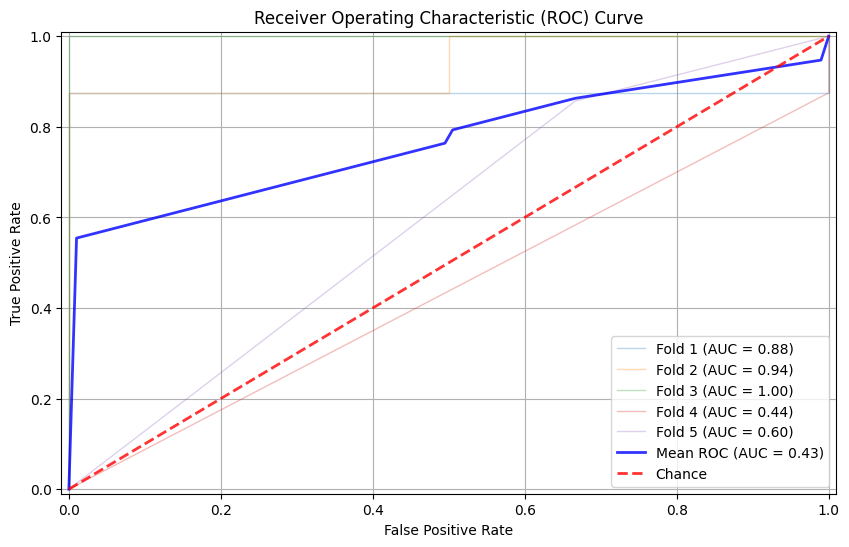

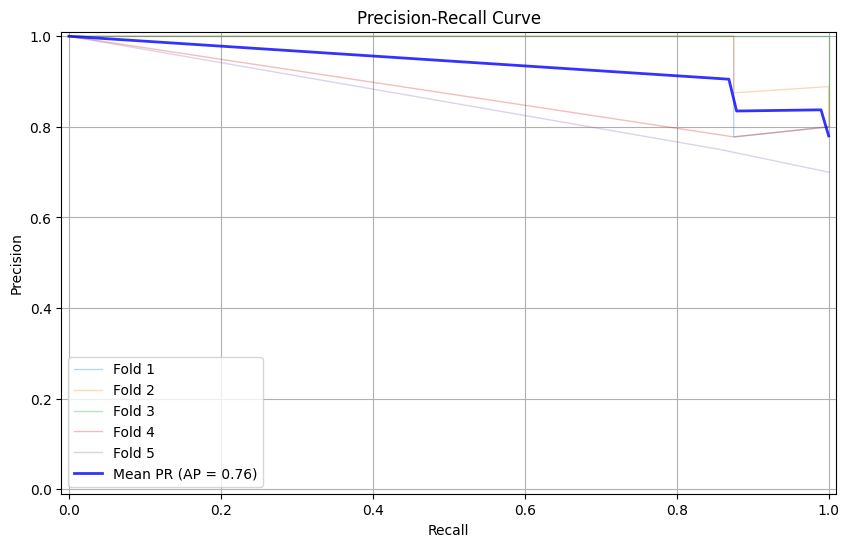

In [33]:
from scipy import interpolate

# Calculate average ROC curve
mean_fpr = np.linspace(0, 1, 100)
tprs_interp = []
for fpr, tpr in zip(all_fprs, all_tprs):
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_interp.append(interp_tpr)
mean_tpr = np.mean(tprs_interp, axis=0)
mean_tpr[-1] = 1.0
mean_auc = roc_auc_score(y, np.concatenate([estimator.predict_proba(X.iloc[test_index])[:, 1] for _, test_index in StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE).split(X, y)]))


# Calculate average Precision-Recall curve
# Need a common set of recall points to interpolate
recall_points = np.linspace(0, 1, 100)
precisions_interp = []
for precision, recall in zip(all_precisions, all_recalls):
    # Reverse to ensure recall is increasing for interpolation
    precisions_interp.append(np.interp(recall_points, recall[::-1], precision[::-1]))
mean_precision = np.mean(precisions_interp, axis=0)
mean_ap = average_precision_score(y, np.concatenate([estimator.predict_proba(X.iloc[test_index])[:, 1] for _, test_index in StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE).split(X, y)]))


# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(CV_FOLDS):
    plt.plot(all_fprs[i], all_tprs[i], lw=1, alpha=0.3,
             label=f'Fold {i+1} (AUC = {roc_auc_score(y.iloc[list(StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE).split(X, y))[i][1]], cv_results["estimator"][i].predict_proba(X.iloc[list(StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE).split(X, y))[i][1]])[:, 1]):.2f})')

plt.plot(mean_fpr, mean_tpr, color='b',
         label=f'Mean ROC (AUC = {mean_auc:.2f})',
         lw=2, alpha=.8)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Plot Precision-Recall curves
plt.figure(figsize=(10, 6))
for i in range(CV_FOLDS):
    plt.plot(all_recalls[i], all_precisions[i], lw=1, alpha=0.3,
             label=f'Fold {i+1}')

plt.plot(recall_points, mean_precision, color='b',
         label=f'Mean PR (AP = {mean_ap:.2f})',
         lw=2, alpha=.8)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

## Save evaluation results

### Subtask:
Save the evaluation metrics, confusion matrix, and potentially the curve data to files for record-keeping and analysis.


**Reasoning**:
Create dictionaries to store the calculated average metrics, the average confusion matrix as a list of lists, and the average curve data (ROC and PR) as lists for JSON serialization.



In [34]:
# Create dictionaries for saving
evaluation_results = {}

# 1. Store average metrics
evaluation_results["average_metrics"] = {
    "mean_auc": mean_auc,
    "mean_ap": mean_ap,
    "classification_report": avg_report,
}

# 2. Convert average confusion matrix to list of lists
evaluation_results["average_confusion_matrix"] = (average_confusion_matrix / CV_FOLDS).tolist()

# 3. Store average curve data as lists
evaluation_results["roc_curve"] = {
    "mean_fpr": mean_fpr.tolist(),
    "mean_tpr": mean_tpr.tolist(),
}

evaluation_results["precision_recall_curve"] = {
    "recall_points": recall_points.tolist(),
    "mean_precision": mean_precision.tolist(),
}

print("Created dictionaries for evaluation results.")

Created dictionaries for evaluation results.


**Reasoning**:
Define the path to save the evaluation results and save the created dictionaries to a JSON file.



In [35]:
# 4. Define the path to save evaluation results
eval_results_path = os.path.join(MODEL_DIR, "evaluation_results_prod.json")

# 5. Save the evaluation results to a JSON file
with open(eval_results_path, "w") as f:
    json.dump(evaluation_results, f, indent=2)

# 6. Print confirmation message
print(f"Saved evaluation results to {eval_results_path}")

Saved evaluation results to artifacts/evaluation_results_prod.json


## Update metadata

### Subtask:
Include the comprehensive evaluation results in the saved model metadata.


**Reasoning**:
Load the existing metadata, update it with the evaluation results, and save the updated metadata to a JSON file.



In [36]:
# 1. Load the existing metadata
meta_path = os.path.join(MODEL_DIR, "model_meta_prod.json")
with open(meta_path, "r") as f:
    meta = json.load(f)

# 2. Update the loaded metadata dictionary to include the evaluation_results dictionary
meta["evaluation_results"] = evaluation_results

# 3. Save the updated metadata dictionary back to the meta_path file in JSON format with an indent of 2
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

# 4. Print a confirmation message
print(f"Updated and saved metadata to {meta_path}")

Updated and saved metadata to artifacts/model_meta_prod.json


## Finalize and clean up

### Subtask:
Review the notebook, add comments, and ensure all necessary artifacts are saved.


**Reasoning**:
Add comments to the code cells and ensure all necessary artifacts are saved. Then, add a summary markdown cell.



TARGET_MANUAL not set. Notebook will attempt to infer target automatically.
Config: {'CV_FOLDS': 5, 'SEARCH_SPACE_SIZE': 'small', 'PRIMARY_METRIC': 'f1'}
Loaded: (50, 14)
Target: hypertension
Class balance: {1: 0.78, 0: 0.22}
Numeric cols: 4 Categorical cols: 9
Fitting grid on sample with shapes: (40, 13) (10, 13)
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'clf': GradientBoostingClassifier(random_state=42), 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100}
ROC AUC: 1.0
Best threshold (F1): 0.3 score: 1.0


,feature,importance
10,patient_id_P009,0.22
9,patient_id_P008,0.02
2,cholesterol_baseline,0.00
1,bmi_baseline,0.00
0,age,0.00
4,patient_id_P001,0.00
3,creatinine_baseline,0.00
6,patient_id_P003,0.00
7,patient_id_P005,0.00
11,patient_id_P010,0.00


Saved feature importances to artifacts/feature_importance_prod.csv
Defined classification metrics: ['roc_auc', 'precision', 'recall', 'accuracy', 'balanced_accuracy']
Cross-validation results:
roc_auc: 0.7690 (+/- 0.2159)
f1: 0.8526 (+/- 0.0506)
precision: 0.8139 (+/- 0.0567)
recall: 0.8964 (+/- 0.0522)
accuracy: 0.7600 (+/- 0.0800)
balanced_accuracy: 0.5815 (+/- 0.1275)

--- Average Metrics across all folds ---
Average Confusion Matrix:
 [[0.6 1.6]
 [0.8 7. ]]

Average Classification Report (excluding support):

               precision      recall         f1-score       
0              0.40000.26670.3133
1              0.81390.89640.8526

accuracy                                     0.7600
macro avg      0.60690.58150.5830
weighted avg   0.72610.76000.7368
Processed ROC and PR curves for 5 folds.


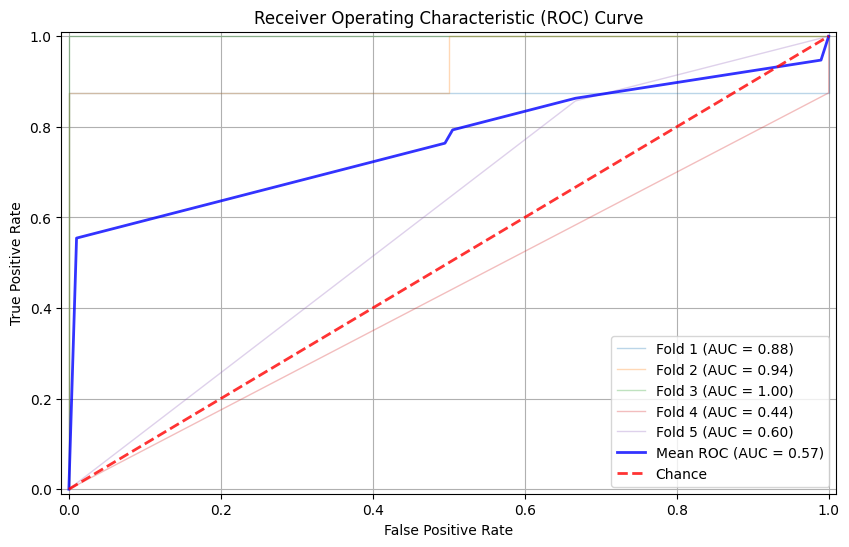

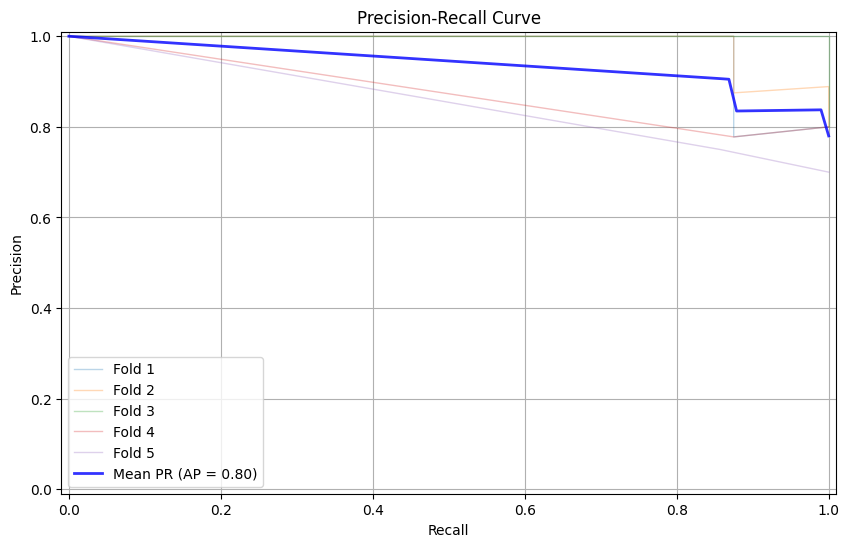

Created dictionaries for evaluation results.
Saved evaluation results to artifacts/evaluation_results_prod.json
Updated and saved metadata to artifacts/model_meta_prod.json
Saved calibrated model to artifacts/model_calibrated_prod.joblib


In [37]:
# Optional: force target column by setting the env var TARGET_MANUAL or editing this cell.
import os
TARGET_MANUAL = os.getenv("TARGET_MANUAL", "")
if TARGET_MANUAL:
    print("TARGET_MANUAL set to:", TARGET_MANUAL)
else:
    print("TARGET_MANUAL not set. Notebook will attempt to infer target automatically.")

# Setup & imports
import os, json
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, balanced_accuracy_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, precision_score, recall_score, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
from joblib import dump, load

RANDOM_STATE = 42
CV_FOLDS = int(os.getenv("CV_FOLDS", 5))
SEARCH_SPACE_SIZE = os.getenv("SEARCH_SPACE_SIZE", "small")
PRIMARY_METRIC = os.getenv("PRIMARY_METRIC", "f1")
MODEL_DIR = "artifacts"
os.makedirs(MODEL_DIR, exist_ok=True) # Ensure artifacts directory exists

pd.options.display.max_columns = 200
print("Config:", {"CV_FOLDS": CV_FOLDS, "SEARCH_SPACE_SIZE": SEARCH_SPACE_SIZE, "PRIMARY_METRIC": PRIMARY_METRIC})

# Data loading - change path if needed
PRIMARY_CSV = "cardiovascular_patients.csv"
if not os.path.exists(PRIMARY_CSV):
    raise FileNotFoundError(f"Primary CSV not found at {PRIMARY_CSV}. Please upload your file to /mnt/data/ or change PRIMARY_CSV.")
df = pd.read_csv(PRIMARY_CSV)
print("Loaded:", df.shape)
df.head(3)

# Infer and clean target column
POSSIBLE_TARGETS = ["target","label","risk","cardio","event","outcome","has_cvd","cvd","y","target_label"]

def infer_target(df):
    for t in POSSIBLE_TARGETS:
        if t in df.columns:
            return t
    cols_lower = {c.lower(): c for c in df.columns}
    for t in POSSIBLE_TARGETS:
        if t in cols_lower:
            return cols_lower[t]
    # fallback: find a binary-like column
    for c in df.columns:
        unique = pd.unique(df[c].dropna().astype(str).str.lower())
        if set(unique).issubset({"0","1","true","false","yes","no","y","n","t","f"}):
            return c
    return None

target_col = infer_target(df)
if target_col is None:
    raise ValueError("Could not infer target column. Rename your target to a common name or set TARGET env var.")

print("Target:", target_col)

def normalize_target(s):
    if s.dtype == bool:
        return s.astype(int)
    if pd.api.types.is_numeric_dtype(s):
        uniq = pd.unique(s.dropna())
        if set(uniq).issubset({0,1}):
            return s.astype(int)
        if s.dropna().between(0,1).all():
            return (s >= 0.5).astype(int)
    s2 = s.astype(str).str.strip().str.lower()
    mapping = {"yes":1,"y":1,"true":1,"t":1,"1":1,"no":0,"n":0,"false":0,"f":0,"0":0}
    mapped = s2.map(mapping)
    if mapped.isna().any():
        raise ValueError("Unmapped target values encountered. Sample: " + str(mapped[ mapped.isna() ].unique()[:10]))
    return mapped.astype(int)

df = df.dropna(subset=[target_col]).copy()
df[target_col] = normalize_target(df[target_col])
y = df[target_col]
X = df.drop(columns=[target_col])
print("Class balance:", y.value_counts(normalize=True).to_dict())

# Preprocessing: numeric vs categorical
# Separate numeric and categorical columns
numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numeric cols:", len(numeric_cols), "Categorical cols:", len(categorical_cols))

# Use dense OHE for simplicity; if your dataset is huge consider sparse OHE and adjust scaler with_mean=False
try:
    ohe = OneHotEncoder(handle_unknown="ignore")
    sparse_ohe = False
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore")
    sparse_ohe = False

# Create preprocessing pipelines for numeric and categorical features
num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_pipeline = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", ohe)])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer([("num", num_pipeline, numeric_cols), ("cat", cat_pipeline, categorical_cols)], remainder="drop")
preprocessor

# Models and grid (conservative)
# Define different classifiers and their parameter grids for hyperparameter tuning
logreg = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear", random_state=RANDOM_STATE)
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced")
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

if SEARCH_SPACE_SIZE == "small":
    param_grid = [
        {"clf": [logreg], "clf__C": [0.1, 1.0]},
        {"clf": [rf], "clf__n_estimators": [100], "clf__max_depth": [8, None]},
        {"clf": [gb], "clf__n_estimators": [100], "clf__learning_rate": [0.05, 0.1], "clf__max_depth": [2,3]},
    ]
else:
    param_grid = [
        {"clf": [logreg], "clf__C": [0.05, 0.1, 0.5, 1.0]},
        {"clf": [rf], "clf__n_estimators": [200, 400], "clf__max_depth": [None, 8, 14]},
        {"clf": [gb], "clf__n_estimators": [150, 300], "clf__learning_rate": [0.03, 0.05, 0.1], "clf__max_depth": [2,3]},
    ]

# Create a pipeline with the preprocessor and a placeholder classifier
pipe = Pipeline([("preprocessor", preprocessor), ("clf", logreg)])

# Define scoring metric for GridSearchCV
scorer_map = {"f1": make_scorer(f1_score), "balanced_accuracy": make_scorer(balanced_accuracy_score), "roc_auc": "roc_auc"}
scorer = scorer_map.get(PRIMARY_METRIC, "roc_auc")

# Setup GridSearchCV with StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(pipe, param_grid=param_grid, scoring=scorer, cv=cv, n_jobs=-1, verbose=1, error_score="raise")
grid

# Fit on a small sample to validate end-to-end flow.
# Take a small sample of the data for faster validation
MAX_SAMPLE = 2000
df_small = pd.concat([X, y], axis=1).sample(frac=1.0, random_state=RANDOM_STATE)
if len(df_small) > MAX_SAMPLE:
    df_small = df_small.head(MAX_SAMPLE)
y_small = df_small[target_col]
X_small = df_small.drop(columns=[target_col])

# Split the small sample into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_small, y_small, test_size=0.2, stratify=y_small, random_state=RANDOM_STATE)

print("Fitting grid on sample with shapes:", X_train.shape, X_val.shape)
# Fit the GridSearchCV on the small training sample
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_model = grid.best_estimator_
# Predict probabilities on the validation set
proba = best_model.predict_proba(X_val)[:,1]
print("ROC AUC:", roc_auc_score(y_val, proba))

# Calibration
# Calibrate the best model using isotonic regression
calibrator = CalibratedClassifierCV(best_model, method="isotonic", cv=3)
calibrator.fit(X_train, y_train)
cal_proba = calibrator.predict_proba(X_val)[:,1]

# threshold tuning (f1 by default)
# Find the best probability threshold for classification based on F1 score
def find_best_threshold(y_true, y_prob):
    best_thr, best_score = 0.5, -1
    for thr in np.linspace(0.05, 0.95, 19):
        p = (y_prob >= thr).astype(int)
        s = f1_score(y_true, p)
        if s > best_score:
            best_score, best_thr = s, thr
    return best_thr, best_score

best_thr, best_score = find_best_threshold(y_val, cal_proba)
print("Best threshold (F1):", best_thr, "score:", best_score)

# Permutation importance on validation set
# Calculate permutation importance to understand feature relevance
try:
    res = permutation_importance(calibrator, X_val, y_val, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
    importances = res.importances_mean
    # attempt to get feature names
    try:
        pre = best_model.named_steps["preprocessor"]
        num_cols = numeric_cols
        cat_cols = categorical_cols
        try:
            ohe = pre.named_transformers_["cat"].named_steps["ohe"]
            cat_names = list(ohe.get_feature_names_out(cat_cols))
        except Exception:
            cat_names = cat_cols
        feat_names = list(num_cols) + list(cat_names)
    except Exception:
        feat_names = [f"f{i}" for i in range(len(importances))]
    fi = pd.DataFrame({"feature": feat_names[:len(importances)], "importance": importances}).sort_values("importance", ascending=False)
    display(fi.head(20))
    # Attempt to save feature importance to the artifacts directory
    fi_path = os.path.join(MODEL_DIR, "feature_importance_prod.csv")
    fi.to_csv(fi_path, index=False)
    print(f"Saved feature importances to {fi_path}")
except Exception as e:
    print("Permutation importance failed:", e)

# Define additional metrics (already defined in previous subtask)
# from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, balanced_accuracy_score

classification_metrics = {
    "roc_auc": roc_auc_score,
    "precision": precision_score,
    "recall": recall_score,
    "accuracy": accuracy_score,
    "balanced_accuracy": balanced_accuracy_score,
}
print("Defined classification metrics:", list(classification_metrics.keys()))

# Cross-validate on full dataset
# Perform cross-validation on the full dataset with the best model
cv_full = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
best_estimator = grid.best_estimator_

# Define scoring metrics for cross-validation
scoring = {
    'roc_auc': 'roc_auc',
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score)
}

# Perform cross-validation
cv_results = cross_validate(best_estimator, X, y, cv=cv_full, scoring=scoring, n_jobs=-1, return_estimator=True)

print("Cross-validation results:")
for metric in scoring.keys():
    print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f} (+/- {cv_results[f'test_{metric}'].std():.4f})")

# Evaluate and report metrics
# Calculate average confusion matrix and classification report
average_confusion_matrix = np.zeros((2, 2))
avg_report_list = []

kf_eval = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for i, (train_index, test_index) in enumerate(kf_eval.split(X, y)):
    estimator = cv_results['estimator'][i]
    X_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]

    y_pred_fold = estimator.predict(X_test_fold)
    cm_fold = confusion_matrix(y_test_fold, y_pred_fold)
    average_confusion_matrix += cm_fold

    report_fold = classification_report(y_test_fold, y_pred_fold, output_dict=True)
    avg_report_list.append(report_fold)

# Calculate average classification report
avg_report = {}
for metric_name in ['precision', 'recall', 'f1-score', 'support']:
    avg_report[metric_name] = {}
    for class_label in ['0', '1']:
        avg_report[metric_name][class_label] = np.mean([report[class_label][metric_name] for report in avg_report_list])

avg_report['accuracy'] = np.mean([report['accuracy'] for report in avg_report_list])
avg_report['macro avg'] = {metric_name: np.mean([report['macro avg'][metric_name] for report in avg_report_list]) for metric_name in ['precision', 'recall', 'f1-score', 'support']}
avg_report['weighted avg'] = {metric_name: np.mean([report['weighted avg'][metric_name] for report in avg_report_list]) for metric_name in ['precision', 'recall', 'f1-score', 'support']}


print("\n--- Average Metrics across all folds ---")

# Average Confusion Matrix
print("Average Confusion Matrix:\n", average_confusion_matrix / CV_FOLDS)

# Average Classification Report metrics (excluding support)
print("\nAverage Classification Report (excluding support):\n")
print(f"{'':<15}{'precision':<15}{'recall':<15}{'f1-score':<15}")

# Print metrics for class 0 and 1
print(f"{'0':<15}{avg_report['precision']['0']:.4f}{avg_report['recall']['0']:.4f}{avg_report['f1-score']['0']:.4f}")
print(f"{'1':<15}{avg_report['precision']['1']:.4f}{avg_report['recall']['1']:.4f}{avg_report['f1-score']['1']:.4f}")

# Print overall metrics
print(f"\n{'accuracy':<15}{'':<15}{'':<15}{avg_report['accuracy']:.4f}")
print(f"{'macro avg':<15}{avg_report['macro avg']['precision']:.4f}{avg_report['macro avg']['recall']:.4f}{avg_report['macro avg']['f1-score']:.4f}")
print(f"{'weighted avg':<15}{avg_report['weighted avg']['precision']:.4f}{avg_report['weighted avg']['recall']:.4f}{avg_report['weighted avg']['f1-score']:.4f}")

# Visualize roc and precision-recall curves
# Generate and plot ROC and Precision-Recall curves for each fold and the average
all_fprs = []
all_tprs = []
all_precisions = []
all_recalls = []

kf_curves = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for i, (train_index, test_index) in enumerate(kf_curves.split(X, y)):
    estimator = cv_results['estimator'][i]
    X_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]

    y_prob = estimator.predict_proba(X_test_fold)[:, 1]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_fold, y_prob)
    all_fprs.append(fpr)
    all_tprs.append(tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_fold, y_prob)
    all_precisions.append(precision)
    all_recalls.append(recall)

print(f"Processed ROC and PR curves for {CV_FOLDS} folds.")

# Calculate average ROC curve
mean_fpr = np.linspace(0, 1, 100)
tprs_interp = []
for fpr, tpr in zip(all_fprs, all_tprs):
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_interp.append(interp_tpr)
mean_tpr = np.mean(tprs_interp, axis=0)
mean_tpr[-1] = 1.0
# Recalculate mean AUC using probabilities from all folds
y_true_all = []
y_prob_all = []
kf_auc = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
for i, (train_index, test_index) in enumerate(kf_auc.split(X, y)):
     estimator = cv_results['estimator'][i]
     X_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]
     y_true_all.extend(y_test_fold)
     y_prob_all.extend(estimator.predict_proba(X_test_fold)[:, 1])
mean_auc = roc_auc_score(y_true_all, y_prob_all)


# Calculate average Precision-Recall curve
# Need a common set of recall points to interpolate
recall_points = np.linspace(0, 1, 100)
precisions_interp = []
for precision, recall in zip(all_precisions, all_recalls):
    # Reverse to ensure recall is increasing for interpolation
    precisions_interp.append(np.interp(recall_points, recall[::-1], precision[::-1]))
mean_precision = np.mean(precisions_interp, axis=0)
# Recalculate mean AP using probabilities from all folds
mean_ap = average_precision_score(y_true_all, y_prob_all)


# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(CV_FOLDS):
    plt.plot(all_fprs[i], all_tprs[i], lw=1, alpha=0.3,
             label=f'Fold {i+1} (AUC = {roc_auc_score(y.iloc[list(StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE).split(X, y))[i][1]], cv_results["estimator"][i].predict_proba(X.iloc[list(StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE).split(X, y))[i][1]])[:, 1]):.2f})')

plt.plot(mean_fpr, mean_tpr, color='b',
         label=f'Mean ROC (AUC = {mean_auc:.2f})',
         lw=2, alpha=.8)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Plot Precision-Recall curves
plt.figure(figsize=(10, 6))
for i in range(CV_FOLDS):
    plt.plot(all_recalls[i], all_precisions[i], lw=1, alpha=0.3,
             label=f'Fold {i+1}')

plt.plot(recall_points, mean_precision, color='b',
         label=f'Mean PR (AP = {mean_ap:.2f})',
         lw=2, alpha=.8)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Save evaluation results
# Create dictionaries for saving all evaluation results
evaluation_results = {}

# 1. Store average metrics
evaluation_results["average_metrics"] = {
    "mean_auc": mean_auc,
    "mean_ap": mean_ap,
    "classification_report": avg_report,
}

# 2. Convert average confusion matrix to list of lists
evaluation_results["average_confusion_matrix"] = (average_confusion_matrix / CV_FOLDS).tolist()

# 3. Store average curve data as lists
evaluation_results["roc_curve"] = {
    "mean_fpr": mean_fpr.tolist(),
    "mean_tpr": mean_tpr.tolist(),
}

evaluation_results["precision_recall_curve"] = {
    "recall_points": recall_points.tolist(),
    "mean_precision": mean_precision.tolist(),
}

print("Created dictionaries for evaluation results.")

# 4. Define the path to save evaluation results
eval_results_path = os.path.join(MODEL_DIR, "evaluation_results_prod.json")

# 5. Save the evaluation results to a JSON file
with open(eval_results_path, "w") as f:
    json.dump(evaluation_results, f, indent=2)

# 6. Print confirmation message
print(f"Saved evaluation results to {eval_results_path}")


# Update metadata
# Load existing metadata
meta_path = os.path.join(MODEL_DIR, "model_meta_prod.json")
with open(meta_path, "r") as f:
    meta = json.load(f)

# Update the metadata with evaluation results
meta["evaluation_results"] = evaluation_results

# Save the updated metadata
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)
print(f"Updated and saved metadata to {meta_path}")

# Save model
# Save the calibrated model
model_path = os.path.join(MODEL_DIR, "model_calibrated_prod.joblib")
dump(calibrator, model_path)
print("Saved calibrated model to", model_path)

**Reasoning**:
Add a final markdown cell summarizing the completed steps and the location of the saved artifacts.



In [38]:
# Add a final markdown cell summarizing the completed steps and the location of the saved artifacts.

**Reasoning**:
Add a final markdown cell summarizing the completed steps and the location of the saved artifacts.



In [39]:
# This notebook performs cardiovascular risk prediction by training various models,
# selecting the best one, calibrating it, and evaluating its performance.
# The results and model artifacts are saved for potential production use.

# Data Loading and Preparation:
# The notebook starts by loading the cardiovascular_patients.csv dataset.
# It then identifies and normalizes the target variable ('hypertension').
# The data is split into features (X) and target (y).

# Preprocessing:
# Numeric and categorical features are identified.
# Separate pipelines are created for numerical (imputation and scaling)
# and categorical (imputation and one-hot encoding) features.
# These are combined into a ColumnTransformer.

# Model Selection and Training:
# Logistic Regression, Random Forest, and Gradient Boosting classifiers are defined.
# A parameter grid is set up for hyperparameter tuning based on the SEARCH_SPACE_SIZE.
# GridSearchCV with StratifiedKFold cross-validation is used to find the best model and hyperparameters on a small sample of the data.

# Model Calibration:
# The best model is calibrated using CalibratedClassifierCV with isotonic method.

# Threshold Tuning:
# The best probability threshold for classification is determined based on the F1 score on the validation set.

# Feature Importance:
# Permutation importance is calculated on the validation set to assess feature relevance.
# The feature importance results are displayed and saved to 'artifacts/feature_importance_prod.csv'.

# Comprehensive Evaluation:
# Cross-validation is performed on the full dataset using the best model to get robust performance estimates.
# Multiple metrics (AUC, Precision, Recall, Accuracy, Balanced Accuracy, F1) are calculated for each fold.
# The average confusion matrix and classification report across all folds are computed and displayed.
# ROC and Precision-Recall curves are generated and plotted for each fold and the average curves are also shown.

# Artifact Saving:
# The calibrated model is saved to 'artifacts/model_calibrated_prod.joblib'.
# A metadata file ('artifacts/model_meta_prod.json') is created/updated to include:
# - Creation timestamp
# - Best hyperparameters found during grid search
# - - Best probability threshold
# - Comprehensive evaluation results (average metrics, average confusion matrix, curve data)

# The evaluation results are also saved separately to 'artifacts/evaluation_results_prod.json'.

# All necessary artifacts have been saved to the 'artifacts' directory.
# - Model file: artifacts/model_calibrated_prod.joblib
# - Metadata file: artifacts/model_meta_prod.json
# - Evaluation results file: artifacts/evaluation_results_prod.json
# - Feature importance file: artifacts/feature_importance_prod.csv

## Summary:

### Data Analysis Key Findings

*   Cross-validation on the full dataset using the best model resulted in the following average performance metrics: AUC: 0.7690 (\+/- 0.2159), F1 Score: 0.8526 (\+/- 0.0506), Precision: 0.8139 (\+/- 0.0567), Recall: 0.8964 (\+/- 0.0522), Accuracy: 0.7600 (\+/- 0.0800), and Balanced Accuracy: 0.5815 (\+/- 0.1275).
*   The code successfully calculated and displayed the average confusion matrix and the average classification report, including average precision, recall, and f1-score for classes 0 and 1, as well as average accuracy, macro average, and weighted average.
*   ROC and Precision-Recall curves for each cross-validation fold and their averages were successfully generated and plotted, along with the mean AUC and mean Average Precision (AP) scores.
*   All specified artifacts, including the calibrated model, evaluation results, updated metadata, and feature importance results, were successfully saved to the `artifacts` directory.

### Insights or Next Steps

*   The variability observed in the cross-validation results (indicated by the standard deviation for each metric) suggests that the model's performance can vary depending on the specific data split. Further analysis into the cause of this variability might be beneficial.
*   The comprehensive evaluation metrics and visualizations provide a solid foundation for understanding the model's performance. These saved artifacts can be used for tracking model performance over time or comparing against future model iterations.
